In [1]:
!pip install -q gensim scikit-learn nltk

In [2]:
import pandas as pd
import numpy as np
import pickle

from gensim.models import Word2Vec
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, accuracy_score, hamming_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, Conv1D, Bidirectional, LSTM
from tensorflow.keras.layers import GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

In [3]:
df = pd.read_csv('uk_fixwanita.csv')
df['label_list'] = df['label_UK'].str.split(', ')
df

,ï»¿created_at,full_text,username,label_UK,case_folding,clean_text,tokenize,stopword_removal,stemming,label_list
0,Tue Apr 01 03:31:02 +0000 2025,no patriarki di keluarga gua since my mother a...,dhislhc,UK_patriarki,no patriarki di keluarga gua since my mother a...,no patriarki di keluarga gua since my mother a...,"['no', 'patriarki', 'di', 'keluarga', 'gua', '...","['no', 'patriarki', 'keluarga', 'since', 'my',...","['no', 'patriark', 'keluarga', 'since', 'my', ...",[UK_patriarki]
1,Sat Mar 29 14:22:50 +0000 2025,Wlgt benerbener pelajaran hidup banget mungkin...,tenniewinibiti,UK_patriarki,wlgt benerbener pelajaran hidup banget mungkin...,wlgt benerbener pelajaran hidup banget mungkin...,"['wlgt', 'benerbener', 'pelajaran', 'hidup', '...","['wlgt', 'benerbener', 'pelajaran', 'hidup', '...","['wlgt', 'benerbener', 'ajar', 'hidup', 'mungk...",[UK_patriarki]
2,Wed Mar 12 15:39:25 +0000 2025,GUE UDAH NGELAKUIN INI SINCE PERBAIKOTAN ITU P...,wdnrvzy,UK_patriarki,gue udah ngelakuin ini since perbaikotan itu p...,gue udah ngelakuin ini since perbaikotan itu p...,"['gue', 'udah', 'ngelakuin', 'ini', 'since', '...","['ngelakuin', 'since', 'perbaikotan', 'plus', ...","['ngelakuin', 'since', 'perbaikotan', 'plus', ...",[UK_patriarki]
3,Fri Mar 07 16:22:37 +0000 2025,well ive been the novel reader since 22 bahkan...,plaveshinki,"UK_misogyny, UK_patriarki, UK_victim",well ive been the novel reader since 22 bahkan...,well ive been the novel reader since 22 bahkan...,"['well', 'ive', 'been', 'the', 'novel', 'reade...","['well', 'ive', 'been', 'the', 'novel', 'reade...","['well', 'ive', 'been', 'the', 'novel', 'reade...","[UK_misogyny, UK_patriarki, UK_victim]"
4,Tue Feb 25 03:59:27 +0000 2025,Perempuan jongos patriarki itu level menjijikk...,aliciasoetopo,UK_patriarki,perempuan jongos patriarki itu level menjijikk...,perempuan jongos patriarki itu level menjijikk...,"['perempuan', 'jongos', 'patriarki', 'itu', 'l...","['perempuan', 'jongos', 'patriarki', 'level', ...","['perempuan', 'jongos', 'patriark', 'level', '...",[UK_patriarki]
...,...,...,...,...,...,...,...,...,...,...
9924,Sat Mar 23 16:53:56 +0000 2024,Betina,AkbarAgasaki,UK_misogyny,betina,betina,['betina'],['betina'],['betina'],[UK_misogyny]
9925,Sat Mar 23 13:33:33 +0000 2024,Hihihihihi ejke betina ye Ketikan lu laki2 ban...,Atheis_Bergitar,UK_misogyny,hihihihihi ejke betina ye ketikan lu laki2 ban...,hihihihihi ejke betina ye ketikan lu laki2 ban...,"['hihihihihi', 'ejke', 'betina', 'ye', 'ketika...","['hihihihihi', 'ejke', 'betina', 'ketikan', 'l...","['hihihihihi', 'ejke', 'betina', 'keti', 'laki...",[UK_misogyny]
9926,Sat Mar 23 11:39:00 +0000 2024,Dasar betina rahim anget,AkbarAgasaki,UK_misogyny,dasar betina rahim anget,dasar betina rahim anget,"['dasar', 'betina', 'rahim', 'anget']","['dasar', 'betina', 'rahim', 'anget']","['dasar', 'betina', 'rahim', 'anget']",[UK_misogyny]
9927,Fri Mar 22 21:00:58 +0000 2024,Junjungan lo kan sdh menang terpilih eh masih ...,Ibnu07338018,UK_misogyny,junjungan lo kan sdh menang terpilih eh masih ...,junjungan lo kan sdh menang terpilih eh masih ...,"['junjungan', 'lo', 'kan', 'sdh', 'menang', 't...","['junjungan', 'lo', 'kan', 'sdh', 'menang', 't...","['junjung', 'lo', 'kan', 'sdh', 'menang', 'pil...",[UK_misogyny]


In [4]:
df['label_list'] = df['label_UK'].apply(lambda x: [l.strip() for l in x.split(',')])
texts = df['stemming'].astype(str).tolist()
labels = df['label_list'].tolist()

In [7]:
import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize

sentences = df['stemming'].astype(str).apply(lambda x: x.split()).tolist()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
w2v_model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=1, workers=4, sg=1)
embedding_dim = 100

In [10]:
from tensorflow.keras.layers import TextVectorization

max_vocab_size = 10000
max_sequence_length = 100
vectorize_layer = TextVectorization(
    max_tokens=max_vocab_size,
    output_mode='int',
    output_sequence_length=max_sequence_length
)

vectorize_layer.adapt(df['stemming'].astype(str))


In [11]:
vocab = vectorize_layer.get_vocabulary()

pretrained_embeddings = np.array([
    w2v_model.wv[word] if word in w2v_model.wv else np.random.normal(0, 1, size=(embedding_dim,))
    for word in vocab
])

In [13]:
tweet_lengths = df['stemming'].astype(str).apply(lambda x: len(x.split()))
tweet_lengths.describe()

,stemming
count,9929.000000
mean,19.924262
std,11.971852
min,1.000000
25%,10.000000
50%,18.000000
75%,30.000000
max,54.000000


In [15]:
max_len = 100
max_features = 10000
embedding_dim = 100

tokenizer = Tokenizer(num_words=max_features, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

x_seq = tokenizer.texts_to_sequences(texts)
x_padded = pad_sequences(x_seq, padding='post', maxlen=max_len)

word_index = tokenizer.word_index
vocab_size = min(max_features, len(word_index) + 1)

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if i >= max_features:
        continue
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
    else:
        embedding_matrix[i] = np.random.normal(0, 1, embedding_dim)

In [16]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(labels)

x_train, x_test, y_train, y_test = train_test_split(x_padded, y, test_size=0.2, random_state=42)

In [17]:
print(f"Jumlah data training: {len(x_train)}")
print(f"Jumlah data testing : {len(x_test)}")

Jumlah data training: 7943
Jumlah data testing : 1986


In [18]:
sequence_input = Input(shape=(max_len,))
embedded = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=True)(sequence_input)
dropout = SpatialDropout1D(0.2)(embedded)
conv = Conv1D(64, kernel_size=3, padding='valid', kernel_initializer='glorot_uniform')(dropout)
lstm = Bidirectional(LSTM(128, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(conv)
pooled = GlobalAveragePooling1D()(lstm)
dense = Dense(128, activation='relu')(pooled)
drop = Dropout(0.1)(dense)
preds = Dense(len(mlb.classes_), activation='sigmoid')(drop)

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=1e-3), metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 100, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 98, 64)         │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 98, 256)        │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,250,437 (4.77 MB)

 Trainable params: 1,250,437 (4.77 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
history = model.fit(x_train,
                    y_train,
                    batch_size=64,
                    epochs=20,
                    validation_split=0.2)

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 63s 623ms/step - accuracy: 0.9035 - loss: 0.0539 - val_accuracy: 0.8729 - val_loss: 0.1243
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 55s 553ms/step - accuracy: 0.9049 - loss: 0.0551 - val_accuracy: 0.8748 - val_loss: 0.1359
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 85s 577ms/step - accuracy: 0.9142 - loss: 0.0487 - val_accuracy: 0.8496 - val_loss: 0.1285
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 79s 553ms/step - accuracy: 0.8985 - loss: 0.0528 - val_accuracy: 0.8313 - val_loss: 0.1498
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 557ms/step - accuracy: 0.9038 - loss: 0.0477 - val_accuracy: 0.8376 - val_loss: 0.1526
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 555ms/step - accuracy: 0.8955 - loss: 0.0484 - val_accuracy: 0.8307 - val_loss: 0.1498
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 569ms/step - accuracy: 0.9004 - loss: 0.0425 - val_accuracy: 0.8729 - val_loss: 0.1376
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 555ms/step - accuracy: 0.9025 - loss: 0

In [38]:
hist_df = pd.DataFrame(history.history)
hist_df

,accuracy,loss,val_accuracy,val_loss
0,0.900220,0.058374,0.872876,0.124303
1,0.902581,0.059949,0.874764,0.135881
2,0.905257,0.055136,0.849591,0.128451
3,0.896601,0.054450,0.831340,0.149820
4,0.903683,0.047939,0.837634,0.152633
5,0.901007,0.046822,0.830711,0.149815
6,0.903053,0.043664,0.872876,0.137570
7,0.908404,0.045337,0.840151,0.148491
8,0.906358,0.038222,0.852108,0.156592
9,0.917847,0.039574,0.876023,0.148687


In [39]:

# Evaluate
score = model.evaluate(x_test, y_test, verbose=1)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.8755 - loss: 0.1434
Test Loss: 0.15408876538276672
Test Accuracy: 0.8660624623298645


In [40]:
from sklearn.metrics import classification_report, hamming_loss, accuracy_score

# Predict and evaluate
y_pred = model.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(int)

print("Exact Match Accuracy:", accuracy_score(y_test, y_pred_binary))
print("Hamming Loss:", hamming_loss(y_test, y_pred_binary))
print(classification_report(y_test, y_pred_binary, target_names=mlb.classes_))

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step
Exact Match Accuracy: 0.892245720040282
Hamming Loss: 0.03564954682779456
              precision    recall  f1-score   support

      Non_UK       0.88      0.71      0.79       359
 UK_misogyny       0.89      0.97      0.93       904
  UK_mockery       0.97      0.91      0.94       400
UK_patriarki       0.98      0.99      0.98       328
   UK_victim       0.97      0.92      0.94       250

   micro avg       0.93      0.92      0.92      2241
   macro avg       0.94      0.90      0.92      2241
weighted avg       0.93      0.92      0.92      2241
 samples avg       0.92      0.92      0.92      2241



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


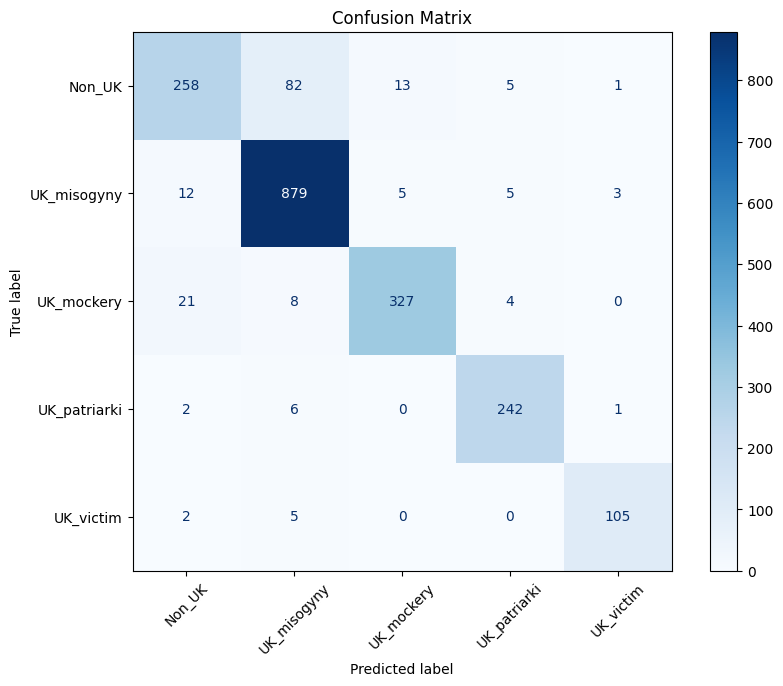

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

y_true_single = np.argmax(y_test, axis=1)
y_pred_single = np.argmax(y_pred_binary, axis=1)

cm = confusion_matrix(y_true_single, y_pred_single)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlb.classes_)
fig, ax = plt.subplots(figsize=(10, 7))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


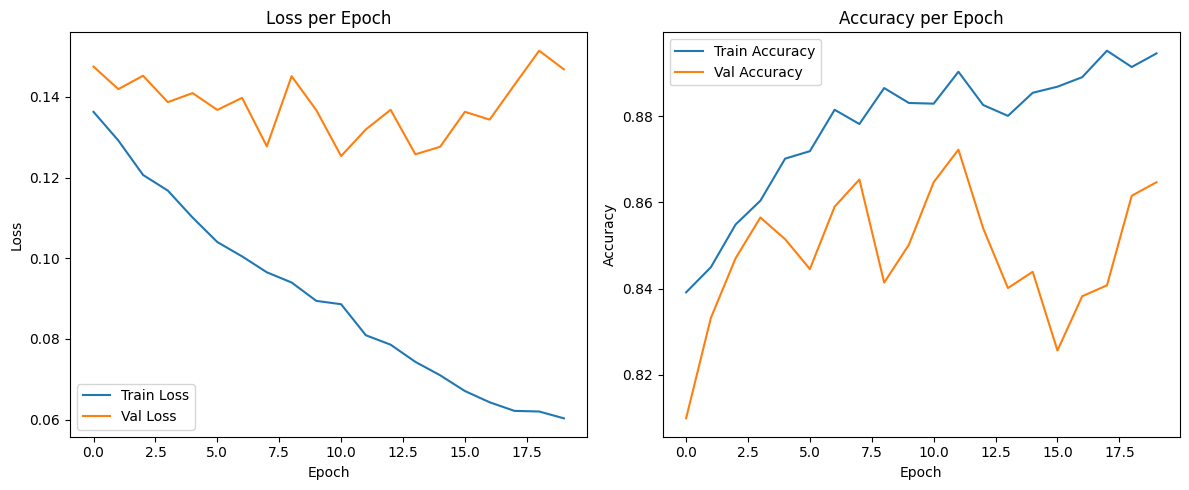

In [35]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

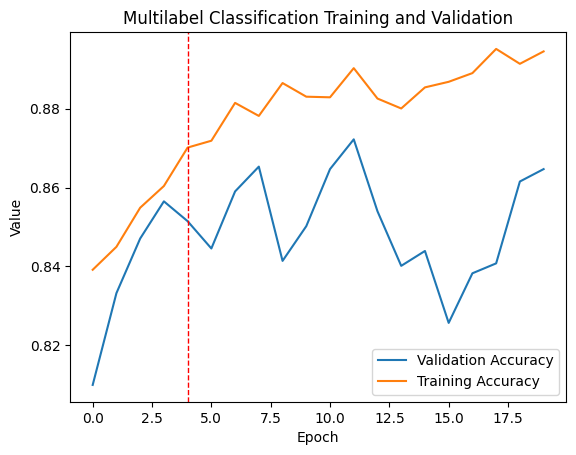

In [36]:
import matplotlib.pyplot as plt

plt.clf()
plt.plot(hist_df['val_accuracy'], label='Validation Accuracy')
plt.plot(hist_df['accuracy'], label='Training Accuracy')
plt.axvline(x = 4, linewidth=1, color='r', linestyle = "--")

plt.title('Multilabel Classification Training and Validation')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

In [ ]:

import joblib

joblib.dump(model, 'model.pkl')
joblib.dump(tokenizer, 'tokenizer.pkl')
joblib.dump(mlb, 'mlb.pkl')

print("✅ Semua file berhasil disimpan.")


In [ ]:
keywords = {
    "UK_victim": [
        "korban", "pikmi", "salah cwe", "salah cewe", "nyalahin",
        "baju", "pakaian", "terbuka", "emang mau", "kenapa gak nolak",
        "ngapain keluar malem", "harusnya diem", "salah sendiri",
        "wajar digituin", "pantes dilecehkan"
    ],
    "UK_patriarki": [
        "patriarki", "feminis", "cwe masak", "cewek di dapur",
        "cewek gak cocok kerja", "wanita harus nurut", "istri harus taat",
        "perempuan ga usah sekolah", "cewek tempatnya di rumah",
        "bisa masak", "harus bisa masak", "cewek harus masak"
    ],
    "UK_misogyny": [
        "goblok", "tolol", "matre", "murahan", "kuliah", "dapur", "betina",
        "nyusahin", "perawan tua", "gatel", "ga laku", "siapa suruh", "cewe hamil",
        "cewek bodoh", "ngapain jadi cewek", "bikin ribet", "cewek brengsek",
        "brengsek lu cewek", "susah ngertiin cewek", "cewek gak berguna", "manja banget"
    ],
    "UK_mockery": [
        "pikmi", "sensi mba", "udah jelek", "cewe gatau diri", "cwe gatau diri",
        "hidup susah", "takut hidup susah", "sok kuat", "bucin banget",
        "cuma modal cantik", "nangis mulu", "mau enaknya doang", "cewek manja",
        "gak bisa mikir", "sok feminis", "pura-pura kuat", "cewek keras kepala",
        "gatau diri", "sensi amat", "sensi"
    ],
    "Non_UK": [
        "baik hati", "baik cantik", "cantik nurut", "imut cantik", "masya allah",
        "tabarakallah", "anak baik", "anak cantik", "baik cantik", "baik kamu",
        "kamu cantik", "baik banget", "cantik banget", "cantik luar dalam", "baik luar dalam",
        "wanita baik", "perempuan cerdas", "perempuan sukses", "wanita kuat", "cewek rajin",
        "perempuan inspiratif", "perempuan hebat", "support wanita", "cewek baik",
        "cewek tangguh", "wanita tangguh", "doa terbaik", "semangat terus", "selalu kuat",
        "hebat banget", "salut sama cewek", "terima kasih", "kamu hebat", "tetap semangat",
        "wanita mandiri", "wanita sabar", "cewek mandiri", "perempuan tangguh",
        "cewek keren", "wanita keren", "wanita inspiratif", "inspirasi banget"
    ]
}

In [ ]:
def predict_text(input_text, threshold=0.5):
    """
    1. Deteksi keyword → kumpulkan semua label yang cocok.
    2. Model‐based multi‐label → semua kelas dengan skor > threshold.
    3. Gabungkan hasil (union) antara keyword‐based & model‐based.
    4. Cetak hasil dan bandingkan dengan ground‐truth di df jika ada.

    Args:
      - input_text: str, kalimat yang ingin diprediksi.
      - threshold: float, ambang batas probabilitas untuk model‐based (default 0.5).

    Return:
      dict berisi:
        - input_text
        - labels_keyword: list hasil keyword‐based
        - labels_model: list hasil model‐based (skor > threshold)
        - labels_final: union keduanya
        - model_probs: dict {label:probabilitas} untuk setiap kelas
        - ground_truth: (opsional) label asli jika ditemukan di df
    """
    text_lower = input_text.lower()

    # 2.1. KEYWORD‐BASED: kumpulkan semua label yang keyword‐nya muncul
    labels_keyword = []
    for label_k, kw_list in keywords.items():
        for kw in kw_list:
            if kw in text_lower:
                if label_k not in labels_keyword:
                    labels_keyword.append(label_k)
                # jangan break, karena mungkin masih ada keyword lain untuk label yang sama atau label lain
        # lanjut ke label berikutnya

    # 2.2. MODEL‐BASED: token → sequence → pad → prediksi → ambil semua label dengan prob > threshold
    # Tokenisasi manual (sama dengan pipeline kamu)
    tokens = input_text.lower().split()
    sequence_input = tokenizer.texts_to_sequences([' '.join(tokens)])
    padded_input = pad_sequences(sequence_input, maxlen=max_len)

    probs = model.predict(padded_input)[0]  # e.g. [0.1, 0.8, 0.65, 0.02, 0.9]
    # Konversi ke dict {label: probability}
    model_probs = {mlb.classes_[i]: float(f"{probs[i]:.3f}") for i in range(len(probs))}
    # Ambil semua klas dengan prob > threshold
    labels_model = [mlb.classes_[i] for i, p in enumerate(probs) if p > threshold]

    # Jika tidak ada label_model (misal semua < threshold), fallback ambil top‐1
    if not labels_model:
        top_idx = int(np.argmax(probs))
        labels_model = [mlb.classes_[top_idx]]

    # 2.3. UNION: gabungkan keyword‐based & model‐based (tanpa duplikasi)
    labels_final = list(dict.fromkeys(labels_keyword + labels_model))  # urutan sesuai kemunculan di list

    # 2.4. CARI GROUND‐TRUTH di df (jika ingin validasi)
    snippet = text_lower[:20]  # potong 20 karakter pertama
    matched_rows = df[df['clean_text'].str.lower().str.contains(snippet, na=False)]
    ground_truth = matched_rows['label_UK'].iloc[0] if not matched_rows.empty else None

    # 2.5. CETAK HASIL
    print("\n=== HASIL MULTI‐LABEL PREDIKSI ===")
    print(f"Teks Input            : {input_text}")
    print(f"Keyword‐Based Labels  : {labels_keyword if labels_keyword else '— tidak ada keyword cocok —'}")
    print(f"Model‐Based Labels    : {labels_model}")
    print(f"Label Final (Union)   : {labels_final}")
    if ground_truth:
        print(f"Label Dataset Asli    : {ground_truth}")
    else:
        print("Label Dataset Asli    : (tidak ditemukan entri serupa)")

    # 2.6. KEMBALIKAN DICT untuk evaluasi jika diperlukan
    return {
        "input_text": input_text,
        "labels_keyword": labels_keyword,
        "labels_model": labels_model,
        "labels_final": labels_final,
        "model_probs": model_probs,
        "ground_truth": ground_truth
    }

In [ ]:
predict_text("maunya cari cewek pinter masak, gausah sekolah kuliah tinggi. harusnya ngaca")